# 02 - Data Preprocessing and Feature Engineering

This notebook performs comprehensive data preprocessing and feature engineering for the financial news sentiment analysis project.

## Objectives:
1. Clean and preprocess raw stock and news data
2. Implement sentiment analysis on news articles
3. Engineer technical indicators and market features
4. Create time-based and lag features
5. Prepare datasets for machine learning models
6. Save processed data for model training

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Add src to path for imports
sys.path.append('../src')

# Configure plotting and warnings
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
# Install required packages for sentiment analysis
%pip install vaderSentiment textblob transformers torch

Note: you may need to restart the kernel to use updated packages.


## 1. Load Raw Data

In [6]:
# Load the data from previous notebook
DATA_PATH = '../data/raw/'
PROCESSED_PATH = '../data/processed/'

# Create processed directory if it doesn't exist
os.makedirs(PROCESSED_PATH, exist_ok=True)

# Load raw data
try:
    stock_df = pd.read_csv(DATA_PATH + 'stock_prices.csv')
    news_df = pd.read_csv(DATA_PATH + 'combined_news.csv')
    print(f"âœ… Data loaded successfully!")
    print(f"Stock data shape: {stock_df.shape}")
    print(f"News data shape: {news_df.shape}")
except FileNotFoundError:
    print("âŒ Raw data not found. Please run notebook 01-data-exploration.ipynb first.")
    raise

âœ… Data loaded successfully!
Stock data shape: (1536, 10)
News data shape: (485, 9)


## 2. Data Cleaning and Preprocessing

In [7]:
# Clean stock data
print("=== CLEANING STOCK DATA ===")

# Convert date column
stock_df['date'] = pd.to_datetime(stock_df['date'])

# Remove any duplicate entries
initial_count = len(stock_df)
stock_df = stock_df.drop_duplicates(subset=['ticker', 'date'])
print(f"Removed {initial_count - len(stock_df)} duplicate stock entries")

# Remove any invalid price data
invalid_mask = (stock_df[['open', 'high', 'low', 'close']] <= 0).any(axis=1)
if invalid_mask.sum() > 0:
    print(f"Removing {invalid_mask.sum()} rows with invalid prices")
    stock_df = stock_df[~invalid_mask]

# Sort by ticker and date
stock_df = stock_df.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f"âœ… Stock data cleaned: {len(stock_df)} rows remaining")

=== CLEANING STOCK DATA ===
Removed 0 duplicate stock entries
âœ… Stock data cleaned: 1536 rows remaining


In [8]:
# Clean news data
print("=== CLEANING NEWS DATA ===")

# Convert timestamp column
news_df['timestamp'] = pd.to_datetime(news_df['timestamp'])

# Remove any duplicate articles
initial_count = len(news_df)
news_df = news_df.drop_duplicates(subset=['ticker', 'headline', 'timestamp'])
print(f"Removed {initial_count - len(news_df)} duplicate news entries")

# Remove articles with missing headlines or content
missing_mask = news_df[['headline', 'content']].isnull().any(axis=1)
if missing_mask.sum() > 0:
    print(f"Removing {missing_mask.sum()} articles with missing headline/content")
    news_df = news_df[~missing_mask]

# Clean text data
news_df['headline'] = news_df['headline'].str.strip()
news_df['content'] = news_df['content'].str.strip()

# Add date column for easier merging
news_df['date'] = news_df['timestamp'].dt.date

print(f"âœ… News data cleaned: {len(news_df)} articles remaining")

=== CLEANING NEWS DATA ===
Removed 0 duplicate news entries
âœ… News data cleaned: 485 articles remaining


## 3. Sentiment Analysis Implementation

In [9]:
# Import sentiment analysis tools
from features.sentiment_analysis import FinancialSentimentAnalyzer

print("=== PERFORMING SENTIMENT ANALYSIS ===")

# Initialize sentiment analyzer
analyzer = FinancialSentimentAnalyzer()

# Analyze headlines
print("Analyzing headline sentiment...")
headline_sentiment = news_df['headline'].apply(analyzer.analyze_text)

# Extract individual sentiment scores based on actual structure
news_df['headline_vader_pos'] = headline_sentiment.apply(lambda x: x['vader_positive'])
news_df['headline_vader_neu'] = headline_sentiment.apply(lambda x: x['vader_neutral'])
news_df['headline_vader_neg'] = headline_sentiment.apply(lambda x: x['vader_negative'])
news_df['headline_vader_compound'] = headline_sentiment.apply(lambda x: x['vader_compound'])

news_df['headline_textblob_polarity'] = headline_sentiment.apply(lambda x: x['textblob_polarity'])
news_df['headline_textblob_subjectivity'] = headline_sentiment.apply(lambda x: x['textblob_subjectivity'])

news_df['headline_finbert_positive'] = headline_sentiment.apply(lambda x: x['finbert_positive'])
news_df['headline_finbert_negative'] = headline_sentiment.apply(lambda x: x['finbert_negative'])
news_df['headline_finbert_neutral'] = headline_sentiment.apply(lambda x: x['finbert_neutral'])

# Extract additional features
news_df['headline_finance_positive_count'] = headline_sentiment.apply(lambda x: x['finance_positive_count'])
news_df['headline_finance_negative_count'] = headline_sentiment.apply(lambda x: x['finance_negative_count'])
news_df['headline_finance_sentiment_ratio'] = headline_sentiment.apply(lambda x: x['finance_sentiment_ratio'])
news_df['headline_composite_sentiment'] = headline_sentiment.apply(lambda x: x['composite_sentiment'])

print("âœ… Headline sentiment analysis completed")

=== PERFORMING SENTIMENT ANALYSIS ===
Analyzing headline sentiment...
Analyzing headline sentiment...
âœ… Headline sentiment analysis completed
âœ… Headline sentiment analysis completed


In [10]:
# Analyze content sentiment (sample only for performance)
print("Analyzing content sentiment (sample)...")

# Take a sample for content analysis to manage computational load
sample_size = min(len(news_df), 100)
sample_indices = np.random.choice(len(news_df), sample_size, replace=False)
content_sample = news_df.iloc[sample_indices].copy()

content_sentiment = content_sample['content'].apply(analyzer.analyze_text)

# Create content sentiment columns with default values (use headline sentiment as proxy for non-sampled)
news_df['content_vader_compound'] = news_df['headline_vader_compound']  
news_df['content_textblob_polarity'] = news_df['headline_textblob_polarity']  
news_df['content_finbert_positive'] = news_df['headline_finbert_positive']  
news_df['content_composite_sentiment'] = news_df['headline_composite_sentiment']

# Update with actual content sentiment for sampled articles using correct structure
for idx, sentiment in zip(sample_indices, content_sentiment):
    news_df.at[idx, 'content_vader_compound'] = sentiment['vader_compound']
    news_df.at[idx, 'content_textblob_polarity'] = sentiment['textblob_polarity']
    news_df.at[idx, 'content_finbert_positive'] = sentiment['finbert_positive']
    news_df.at[idx, 'content_composite_sentiment'] = sentiment['composite_sentiment']

print(f"âœ… Content sentiment analysis completed (sampled {sample_size} articles)")

Analyzing content sentiment (sample)...
âœ… Content sentiment analysis completed (sampled 100 articles)
âœ… Content sentiment analysis completed (sampled 100 articles)


=== SENTIMENT ANALYSIS SUMMARY ===

Sentiment Score Statistics:


,headline_vader_compound,headline_textblob_polarity,headline_finbert_positive
count,485.000000,485.000000,485.000000
mean,0.301287,0.035402,0.170820
std,0.213974,0.150763,0.178233
min,0.000000,-0.131818,0.023641
25%,0.000000,0.000000,0.045656
50%,0.401900,0.000000,0.134289
75%,0.401900,0.000000,0.226493
max,0.636900,0.433333,0.832584


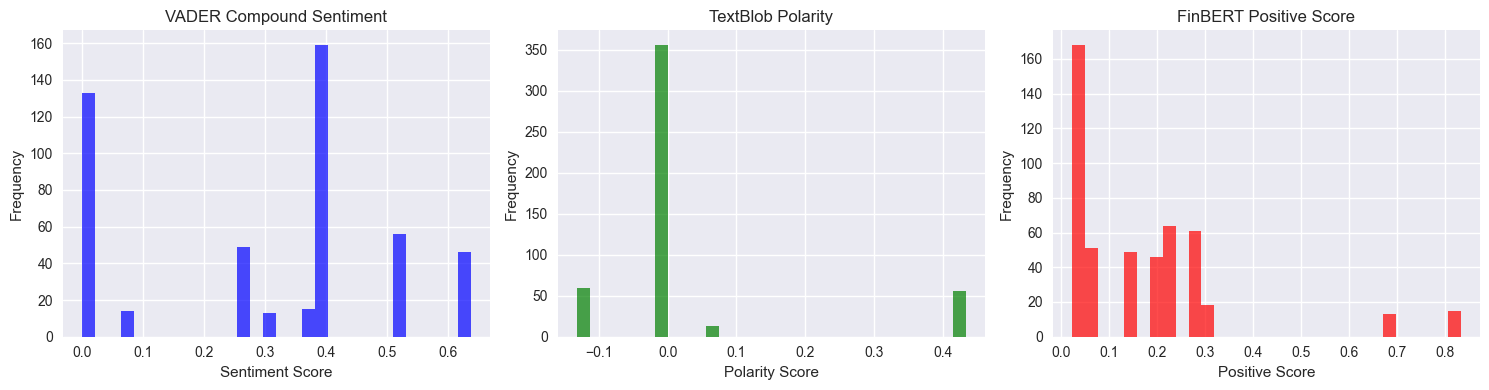

In [11]:
# Display sentiment analysis results
print("=== SENTIMENT ANALYSIS SUMMARY ===")

sentiment_cols = ['headline_vader_compound', 'headline_textblob_polarity', 'headline_finbert_positive']
print("\nSentiment Score Statistics:")
display(news_df[sentiment_cols].describe())

# Plot sentiment distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(news_df['headline_vader_compound'], bins=30, alpha=0.7, color='blue')
axes[0].set_title('VADER Compound Sentiment')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')

axes[1].hist(news_df['headline_textblob_polarity'], bins=30, alpha=0.7, color='green')
axes[1].set_title('TextBlob Polarity')
axes[1].set_xlabel('Polarity Score')
axes[1].set_ylabel('Frequency')

axes[2].hist(news_df['headline_finbert_positive'], bins=30, alpha=0.7, color='red')
axes[2].set_title('FinBERT Positive Score')
axes[2].set_xlabel('Positive Score')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 4. Technical Indicators and Market Features

In [12]:
# Calculate technical indicators
from features.build_features import FeatureEngineering

print("=== CREATING TECHNICAL INDICATORS ===")

# Configure feature engineering
config = {
    'technical_indicators': ['sma_5', 'sma_10', 'sma_20', 'ema_12', 'ema_26', 'rsi_14', 'bb_upper', 'bb_lower', 'macd'],
    'sentiment_lags': [1, 2, 3, 5],
    'return_horizons': [1, 2, 5],
    'volatility_windows': [5, 10, 20]
}

fe = FeatureEngineering(config)

# Calculate basic returns and volatility first
stock_df = stock_df.sort_values(['ticker', 'date'])
stock_df['daily_return'] = stock_df.groupby('ticker')['close'].pct_change()
stock_df['log_return'] = np.log(stock_df['close']).diff()

# Create technical features for each ticker
enhanced_stock_dfs = []

for ticker in stock_df['ticker'].unique():
    ticker_data = stock_df[stock_df['ticker'] == ticker].copy()
    
    # Add placeholder sentiment columns
    ticker_data['vader_compound'] = 0.0
    ticker_data['textblob_polarity'] = 0.0
    
    # Create technical features
    enhanced_data = fe.create_technical_features(ticker_data)
    enhanced_stock_dfs.append(enhanced_data)
    
    print(f"âœ… Created technical features for {ticker}: {enhanced_data.shape[1]} total columns")

# Combine all enhanced stock data
enhanced_stock_df = pd.concat(enhanced_stock_dfs, ignore_index=True)
print(f"\nâœ… Technical indicators created: {enhanced_stock_df.shape}")

=== CREATING TECHNICAL INDICATORS ===
âœ… Created technical features for RR: 48 total columns
âœ… Created technical features for TTWO: 48 total columns
âœ… Created technical features for VWRL.L: 48 total columns

âœ… Technical indicators created: (1536, 48)


In [13]:
# Add time-based features
print("=== CREATING TIME-BASED FEATURES ===")

enhanced_stock_df['year'] = enhanced_stock_df['date'].dt.year
enhanced_stock_df['month'] = enhanced_stock_df['date'].dt.month
enhanced_stock_df['day_of_week'] = enhanced_stock_df['date'].dt.dayofweek
enhanced_stock_df['day_of_month'] = enhanced_stock_df['date'].dt.day
enhanced_stock_df['quarter'] = enhanced_stock_df['date'].dt.quarter
enhanced_stock_df['is_month_end'] = enhanced_stock_df['date'].dt.is_month_end.astype(int)
enhanced_stock_df['is_quarter_end'] = enhanced_stock_df['date'].dt.is_quarter_end.astype(int)

# Market session indicators (assuming US market)
enhanced_stock_df['is_monday'] = (enhanced_stock_df['day_of_week'] == 0).astype(int)
enhanced_stock_df['is_friday'] = (enhanced_stock_df['day_of_week'] == 4).astype(int)

print(f"âœ… Time-based features created: {enhanced_stock_df.shape[1]} total columns")

=== CREATING TIME-BASED FEATURES ===
âœ… Time-based features created: 57 total columns


## 5. News Aggregation and Feature Creation

In [14]:
# Aggregate news data by ticker and date
print("=== AGGREGATING NEWS DATA ===")

# Group news by ticker and date
news_agg = news_df.groupby(['ticker', 'date']).agg({
    'headline': 'count',  # Number of articles
    'headline_vader_compound': ['mean', 'std', 'min', 'max'],
    'headline_textblob_polarity': ['mean', 'std', 'min', 'max'],
    'headline_finbert_positive': ['mean', 'std', 'min', 'max'],
    'content_vader_compound': 'mean',
    'content_textblob_polarity': 'mean',
    'content_finbert_positive': 'mean'
}).reset_index()

# Flatten column names
news_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in news_agg.columns.values]
news_agg = news_agg.rename(columns={
    'ticker_': 'ticker',
    'date_': 'date',
    'headline_count': 'article_count'
})

# Fill NaN values in std columns with 0 (when only one article per day)
std_cols = [col for col in news_agg.columns if 'std' in col]
news_agg[std_cols] = news_agg[std_cols].fillna(0)

print(f"âœ… News aggregated: {news_agg.shape}")
print(f"News features: {list(news_agg.columns)}")

=== AGGREGATING NEWS DATA ===
âœ… News aggregated: (485, 18)
News features: ['ticker', 'date', 'article_count', 'headline_vader_compound_mean', 'headline_vader_compound_std', 'headline_vader_compound_min', 'headline_vader_compound_max', 'headline_textblob_polarity_mean', 'headline_textblob_polarity_std', 'headline_textblob_polarity_min', 'headline_textblob_polarity_max', 'headline_finbert_positive_mean', 'headline_finbert_positive_std', 'headline_finbert_positive_min', 'headline_finbert_positive_max', 'content_vader_compound_mean', 'content_textblob_polarity_mean', 'content_finbert_positive_mean']


In [15]:
# Merge stock and news data
print("=== MERGING STOCK AND NEWS DATA ===")

# Convert stock date to date type for merging
enhanced_stock_df['date_only'] = enhanced_stock_df['date'].dt.date

# Merge datasets
merged_df = enhanced_stock_df.merge(
    news_agg, 
    left_on=['ticker', 'date_only'], 
    right_on=['ticker', 'date'], 
    how='left'
)

# Fill missing news data with zeros
news_cols = [col for col in news_agg.columns if col not in ['ticker', 'date']]
merged_df[news_cols] = merged_df[news_cols].fillna(0)

# Drop duplicate date columns
merged_df = merged_df.drop(['date_only', 'date_y'], axis=1)
merged_df = merged_df.rename(columns={'date_x': 'date'})

print(f"âœ… Data merged: {merged_df.shape}")
print(f"Days with news coverage: {(merged_df['article_count'] > 0).sum()}")
print(f"Days without news: {(merged_df['article_count'] == 0).sum()}")

=== MERGING STOCK AND NEWS DATA ===
âœ… Data merged: (1536, 73)
Days with news coverage: 485
Days without news: 1051


## 6. Feature Engineering and Lag Features

In [16]:
# Create lag features for sentiment
print("=== CREATING LAG FEATURES ===")

# Sort data for lag creation
merged_df = merged_df.sort_values(['ticker', 'date'])

# Create lag features for key sentiment variables
sentiment_vars = ['article_count', 'headline_vader_compound_mean', 'headline_textblob_polarity_mean', 'headline_finbert_positive_mean']
lag_periods = [1, 2, 3, 5]

for var in sentiment_vars:
    for lag in lag_periods:
        merged_df[f'{var}_lag_{lag}'] = merged_df.groupby('ticker')[var].shift(lag)

# Create rolling averages of sentiment
windows = [3, 5, 10]
for var in sentiment_vars:
    for window in windows:
        merged_df[f'{var}_ma_{window}'] = merged_df.groupby('ticker')[var].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )

print(f"âœ… Lag features created: {merged_df.shape[1]} total columns")

=== CREATING LAG FEATURES ===
âœ… Lag features created: 101 total columns


In [17]:
# Create interaction features
print("=== CREATING INTERACTION FEATURES ===")

# Check available columns first
print(f"Available columns: {list(merged_df.columns)}")

# Sentiment-Volume interactions
merged_df['sentiment_volume_interaction'] = (
    merged_df['headline_vader_compound_mean'] * np.log1p(merged_df['volume'])
)

# News count and price volatility (use available volatility column)
volatility_cols = [col for col in merged_df.columns if 'volatility' in col.lower()]
print(f"Available volatility columns: {volatility_cols}")

if volatility_cols:
    volatility_col = volatility_cols[0]  # Use first available volatility column
    merged_df['news_volatility_interaction'] = (
        merged_df['article_count'] * merged_df[volatility_col]
    )
else:
    # Create volatility if not available
    merged_df['volatility_5'] = merged_df.groupby('ticker')['daily_return'].transform(
        lambda x: x.rolling(window=5, min_periods=1).std()
    )
    merged_df['news_volatility_interaction'] = (
        merged_df['article_count'] * merged_df['volatility_5']
    )

# Sentiment consistency (difference between headline and content)
merged_df['sentiment_consistency'] = abs(
    merged_df['headline_vader_compound_mean'] - merged_df['content_vader_compound_mean']
)

# Market momentum features
merged_df['price_momentum_3d'] = merged_df.groupby('ticker')['close'].transform(
    lambda x: x.pct_change(3)
)
merged_df['price_momentum_5d'] = merged_df.groupby('ticker')['close'].transform(
    lambda x: x.pct_change(5)
)

print(f"âœ… Interaction features created: {merged_df.shape[1]} total columns")

=== CREATING INTERACTION FEATURES ===
Available columns: ['date', 'ticker', 'company_name', 'exchange', 'currency', 'open', 'high', 'low', 'close', 'volume', 'daily_return', 'log_return', 'vader_compound', 'textblob_polarity', 'sma_5', 'ema_5', 'price_vs_sma_5', 'sma_10', 'ema_10', 'price_vs_sma_10', 'sma_20', 'ema_20', 'price_vs_sma_20', 'sma_50', 'ema_50', 'price_vs_sma_50', 'volatility_5d', 'high_low_ratio_5d', 'volatility_10d', 'high_low_ratio_10d', 'volatility_20d', 'high_low_ratio_20d', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_lower', 'bb_width', 'bb_position', 'volume_sma_10', 'volume_ratio', 'price_volume', 'price_change_1d', 'price_change_3d', 'price_change_5d', 'is_new_high_20d', 'is_new_low_20d', 'year', 'month', 'day_of_week', 'day_of_month', 'quarter', 'is_month_end', 'is_quarter_end', 'is_monday', 'is_friday', 'article_count', 'headline_vader_compound_mean', 'headline_vader_compound_std', 'headline_vader_compound_min', 'headline_vader_compound_ma

## 7. Target Variable Creation

In [18]:
# Create target variables for different prediction horizons
print("=== CREATING TARGET VARIABLES ===")

# Future return targets
for horizon in [1, 2, 5]:
    merged_df[f'future_return_{horizon}d'] = merged_df.groupby('ticker')['daily_return'].shift(-horizon)
    
    # Binary classification targets (positive/negative returns)
    merged_df[f'future_return_{horizon}d_positive'] = (
        merged_df[f'future_return_{horizon}d'] > 0
    ).astype(int)
    
    # Categorical targets (strong negative, negative, neutral, positive, strong positive)
    returns = merged_df[f'future_return_{horizon}d']
    merged_df[f'future_return_{horizon}d_categorical'] = pd.cut(
        returns,
        bins=[-np.inf, -0.02, -0.005, 0.005, 0.02, np.inf],
        labels=['strong_negative', 'negative', 'neutral', 'positive', 'strong_positive']
    )

# Volatility targets
for horizon in [1, 5]:
    merged_df[f'future_volatility_{horizon}d'] = merged_df.groupby('ticker')['daily_return'].transform(
        lambda x: x.shift(-horizon).rolling(window=horizon).std()
    )

print(f"âœ… Target variables created: {merged_df.shape[1]} total columns")

# Display target variable statistics
target_cols = [col for col in merged_df.columns if 'future_return' in col and 'categorical' not in col]
print("\nTarget Variable Statistics:")
display(merged_df[target_cols].describe())

=== CREATING TARGET VARIABLES ===
âœ… Target variables created: 117 total columns

Target Variable Statistics:


,future_return_1d,future_return_1d_positive,future_return_2d,future_return_2d_positive,future_return_5d,future_return_5d_positive
count,1533.000000,1536.000000,1530.000000,1536.000000,1521.000000,1536.000000
mean,0.000444,0.507161,0.000383,0.505859,0.000598,0.505859
std,0.046237,0.500112,0.046237,0.500128,0.046214,0.500128
min,-0.739437,0.000000,-0.739437,0.000000,-0.739437,0.000000
25%,-0.008559,0.000000,-0.008596,0.000000,-0.008332,0.000000
50%,0.000258,1.000000,0.000256,1.000000,0.000305,1.000000
75%,0.007463,1.000000,0.007429,1.000000,0.007474,1.000000
max,0.670270,1.000000,0.670270,1.000000,0.670270,1.000000


## 8. Data Quality and Feature Selection

In [19]:
# Analyze feature completeness and quality
print("=== FEATURE QUALITY ANALYSIS ===")

# Check missing values
missing_summary = merged_df.isnull().sum()
missing_pct = (missing_summary / len(merged_df)) * 100
missing_df = pd.DataFrame({
    'missing_count': missing_summary,
    'missing_percentage': missing_pct
}).sort_values('missing_percentage', ascending=False)

print(f"Features with >50% missing values: {(missing_df['missing_percentage'] > 50).sum()}")
print(f"Features with >20% missing values: {(missing_df['missing_percentage'] > 20).sum()}")
print(f"Features with >10% missing values: {(missing_df['missing_percentage'] > 10).sum()}")

# Display top missing features
if (missing_df['missing_percentage'] > 10).any():
    print("\nFeatures with >10% missing values:")
    display(missing_df[missing_df['missing_percentage'] > 10].head(10))

# Check for infinite values
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
inf_counts = pd.Series({col: np.isinf(merged_df[col]).sum() for col in numeric_cols})
inf_features = inf_counts[inf_counts > 0]
if len(inf_features) > 0:
    print(f"\nFeatures with infinite values: {len(inf_features)}")
    print(inf_features.head())
else:
    print("\nâœ… No infinite values detected")

=== FEATURE QUALITY ANALYSIS ===
Features with >50% missing values: 1
Features with >20% missing values: 1
Features with >10% missing values: 1

Features with >10% missing values:


,missing_count,missing_percentage
future_volatility_1d,1536,100.0



âœ… No infinite values detected


In [20]:
# Feature correlation analysis
print("=== FEATURE CORRELATION ANALYSIS ===")

# Select numeric features for correlation analysis
numeric_features = merged_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove target variables from feature correlation
feature_cols = [col for col in numeric_features if not col.startswith('future_')]

# Calculate correlation matrix
corr_matrix = merged_df[feature_cols].corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = abs(corr_matrix.iloc[i, j])
        if corr_val > 0.95:  # Threshold for high correlation
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_val
            ))

print(f"Highly correlated feature pairs (>0.95): {len(high_corr_pairs)}")
if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature1', 'Feature2', 'Correlation'])
    display(high_corr_df.head(10))

print(f"\nâœ… Total features available: {len(feature_cols)}")

=== FEATURE CORRELATION ANALYSIS ===
Highly correlated feature pairs (>0.95): 114


,Feature1,Feature2,Correlation
0,open,high,0.999647
1,open,low,0.999676
2,open,close,0.999385
3,open,sma_5,0.999178
4,open,ema_5,0.999439
5,open,sma_10,0.998073
6,open,ema_10,0.998644
7,open,sma_20,0.995720
8,open,ema_20,0.997108
9,open,sma_50,0.988837



âœ… Total features available: 101


## 9. Data Splitting and Scaling

In [21]:
# Prepare final dataset
print("=== PREPARING FINAL DATASET ===")

# Remove rows with missing target variables
final_df = merged_df.dropna(subset=['future_return_1d']).copy()

# Identify numeric and categorical columns
numeric_cols = final_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = final_df.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)} - {categorical_cols}")

# Handle missing values in numeric features only
for col in numeric_cols:
    if col in final_df.columns:
        final_df[col] = final_df.groupby('ticker')[col].fillna(method='ffill').fillna(method='bfill')

# Fill remaining NaN in numeric columns only
final_df[numeric_cols] = final_df[numeric_cols].fillna(0)

# Replace infinite values with NaN then fill (numeric columns only)
final_df[numeric_cols] = final_df[numeric_cols].replace([np.inf, -np.inf], np.nan)
final_df[numeric_cols] = final_df[numeric_cols].fillna(0)

# Handle categorical columns separately - fill missing values with 'unknown' or mode
for col in categorical_cols:
    if col not in ['ticker', 'date']:  # Skip these specific columns
        if final_df[col].dtype.name == 'category':
            # For categorical dtype, handle missing values
            mode_val = final_df[col].mode()[0] if len(final_df[col].mode()) > 0 else 'unknown'
            final_df[col] = final_df[col].cat.add_categories(['unknown']).fillna('unknown')
        else:
            # For other categorical-like columns
            final_df[col] = final_df[col].fillna('unknown')

print(f"âœ… Final dataset prepared: {final_df.shape}")
print(f"Date range: {final_df['date'].min()} to {final_df['date'].max()}")
print(f"Tickers: {sorted(final_df['ticker'].unique())}")

=== PREPARING FINAL DATASET ===
Numeric columns: 109
Categorical columns: 8 - ['date', 'ticker', 'company_name', 'exchange', 'currency', 'future_return_1d_categorical', 'future_return_2d_categorical', 'future_return_5d_categorical']
âœ… Final dataset prepared: (1533, 117)
Date range: 2022-01-03 00:00:00 to 2024-08-29 00:00:00
Tickers: ['RR', 'TTWO', 'VWRL.L']


In [22]:
# Time-based train/validation/test split
print("=== TIME-BASED DATA SPLITTING ===")

# Sort by date
final_df = final_df.sort_values('date')

# Calculate split points (70% train, 15% validation, 15% test)
n_total = len(final_df)
train_end = int(0.7 * n_total)
val_end = int(0.85 * n_total)

train_df = final_df.iloc[:train_end].copy()
val_df = final_df.iloc[train_end:val_end].copy()
test_df = final_df.iloc[val_end:].copy()

print(f"Training set: {len(train_df)} samples ({train_df['date'].min()} to {train_df['date'].max()})")
print(f"Validation set: {len(val_df)} samples ({val_df['date'].min()} to {val_df['date'].max()})")
print(f"Test set: {len(test_df)} samples ({test_df['date'].min()} to {test_df['date'].max()})")

=== TIME-BASED DATA SPLITTING ===
Training set: 1073 samples (2022-01-03 00:00:00 to 2024-01-22 00:00:00)
Validation set: 230 samples (2024-01-22 00:00:00 to 2024-05-10 00:00:00)
Test set: 230 samples (2024-05-10 00:00:00 to 2024-08-29 00:00:00)


In [26]:
# Feature scaling
print("=== FEATURE SCALING ===")

# Identify numeric columns only
numeric_cols = final_df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude target and identifier columns
exclude_cols = ['date', 'ticker', 'company_name', 'exchange', 'currency'] + \
               [col for col in numeric_cols if col.startswith('future_')]
               
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Total numeric columns: {len(numeric_cols)}")
print(f"Feature columns for scaling: {len(feature_cols)}")

# Initialize scalers
scaler = StandardScaler()

# Fit scaler on training data only
train_features = train_df[feature_cols]
scaler.fit(train_features)

# Transform all splits
train_df_scaled = train_df.copy()
val_df_scaled = val_df.copy()
test_df_scaled = test_df.copy()

train_df_scaled[feature_cols] = scaler.transform(train_df[feature_cols])
val_df_scaled[feature_cols] = scaler.transform(val_df[feature_cols])
test_df_scaled[feature_cols] = scaler.transform(test_df[feature_cols])

print(f"✅ Features scaled: {len(feature_cols)} features")
print(f"Feature scaling statistics (train set):")
print(f"  Mean: {train_df_scaled[feature_cols].mean().mean():.6f}")
print(f"  Std: {train_df_scaled[feature_cols].std().mean():.6f}")

=== FEATURE SCALING ===
Total numeric columns: 109
Feature columns for scaling: 101
✅ Features scaled: 101 features
Feature scaling statistics (train set):
  Mean: 0.000000
  Std: 0.941033


## 10. Save Processed Data

In [27]:
# Save processed datasets
print("=== SAVING PROCESSED DATA ===")

# Save unscaled data
train_df.to_csv(PROCESSED_PATH + 'train_data_raw.csv', index=False)
val_df.to_csv(PROCESSED_PATH + 'val_data_raw.csv', index=False)
test_df.to_csv(PROCESSED_PATH + 'test_data_raw.csv', index=False)

# Save scaled data
train_df_scaled.to_csv(PROCESSED_PATH + 'train_data_scaled.csv', index=False)
val_df_scaled.to_csv(PROCESSED_PATH + 'val_data_scaled.csv', index=False)
test_df_scaled.to_csv(PROCESSED_PATH + 'test_data_scaled.csv', index=False)

# Save feature names and metadata
metadata = {
    'feature_columns': feature_cols,
    'target_columns': [col for col in final_df.columns if col.startswith('future_')],
    'categorical_columns': ['ticker', 'future_return_1d_categorical', 'future_return_2d_categorical', 'future_return_5d_categorical'],
    'date_column': 'date',
    'total_features': len(feature_cols),
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'test_samples': len(test_df)
}

import json
with open(PROCESSED_PATH + 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

# Save scaler
import joblib
joblib.dump(scaler, PROCESSED_PATH + 'feature_scaler.pkl')

print(f"âœ… All processed data saved to {PROCESSED_PATH}")
print(f"Files created:")
for file in os.listdir(PROCESSED_PATH):
    print(f"  - {file}")

=== SAVING PROCESSED DATA ===
âœ… All processed data saved to ../data/processed/
Files created:
  - data_summary.txt
  - data_with_sentiment.csv
  - features.csv
  - feature_metadata.csv
  - feature_scaler.pkl
  - feature_summary.txt
  - merged_data.csv
  - metadata.json
  - test_data_raw.csv
  - test_data_scaled.csv
  - train_data_raw.csv
  - train_data_scaled.csv
  - val_data_raw.csv
  - val_data_scaled.csv


## 11. Summary and Next Steps

In [28]:
# Generate preprocessing summary
print("=== PREPROCESSING SUMMARY ===")

print("\n1. DATA PROCESSING:")
print(f"   â€¢ Raw stock data: {len(stock_df)} observations")
print(f"   â€¢ Raw news data: {len(news_df)} articles")
print(f"   â€¢ Final merged dataset: {len(final_df)} observations")
print(f"   â€¢ Data coverage: {(final_df['article_count'] > 0).mean()*100:.1f}% days with news")

print("\n2. FEATURE ENGINEERING:")
print(f"   â€¢ Total features created: {len(feature_cols)}")
print(f"   â€¢ Technical indicators: {len([c for c in feature_cols if any(x in c for x in ['sma', 'ema', 'rsi', 'bb', 'macd'])])}")
print(f"   â€¢ Sentiment features: {len([c for c in feature_cols if 'sentiment' in c or 'vader' in c or 'textblob' in c or 'finbert' in c])}")
print(f"   â€¢ Lag features: {len([c for c in feature_cols if 'lag' in c])}")
print(f"   â€¢ Moving average features: {len([c for c in feature_cols if '_ma_' in c])}")

print("\n3. SENTIMENT ANALYSIS:")
sentiment_stats = final_df[['headline_vader_compound_mean', 'headline_textblob_polarity_mean', 'headline_finbert_positive_mean']].describe()
print(f"   â€¢ VADER compound range: {sentiment_stats.loc['min', 'headline_vader_compound_mean']:.3f} to {sentiment_stats.loc['max', 'headline_vader_compound_mean']:.3f}")
print(f"   â€¢ TextBlob polarity range: {sentiment_stats.loc['min', 'headline_textblob_polarity_mean']:.3f} to {sentiment_stats.loc['max', 'headline_textblob_polarity_mean']:.3f}")
print(f"   â€¢ FinBERT positive range: {sentiment_stats.loc['min', 'headline_finbert_positive_mean']:.3f} to {sentiment_stats.loc['max', 'headline_finbert_positive_mean']:.3f}")

print("\n4. TARGET VARIABLES:")
print(f"   â€¢ 1-day return prediction: {(~final_df['future_return_1d'].isna()).sum()} samples")
print(f"   â€¢ Positive return rate (1d): {final_df['future_return_1d_positive'].mean()*100:.1f}%")
print(f"   â€¢ Average 1-day return: {final_df['future_return_1d'].mean()*100:.3f}%")
print(f"   â€¢ Return volatility (1d): {final_df['future_return_1d'].std()*100:.3f}%")

print("\n5. DATA SPLITS:")
print(f"   â€¢ Training: {len(train_df)} samples ({len(train_df)/len(final_df)*100:.1f}%)")
print(f"   â€¢ Validation: {len(val_df)} samples ({len(val_df)/len(final_df)*100:.1f}%)")
print(f"   â€¢ Test: {len(test_df)} samples ({len(test_df)/len(final_df)*100:.1f}%)")

print("\n6. DATA QUALITY:")
print(f"   â€¢ Missing values in final dataset: {final_df.isnull().sum().sum()}")
print(f"   â€¢ Infinite values handled: âœ…")
print(f"   â€¢ Features scaled: âœ…")
print(f"   â€¢ Highly correlated features (>0.95): {len(high_corr_pairs)}")

print("\n" + "="*50)
print("Preprocessing completed successfully!")
print("Next step: Run notebook 03-model-training.ipynb")
print("="*50)

=== PREPROCESSING SUMMARY ===

1. DATA PROCESSING:
   â€¢ Raw stock data: 1536 observations
   â€¢ Raw news data: 485 articles
   â€¢ Final merged dataset: 1533 observations
   â€¢ Data coverage: 31.5% days with news

2. FEATURE ENGINEERING:
   â€¢ Total features created: 101
   â€¢ Technical indicators: 21
   â€¢ Sentiment features: 40
   â€¢ Lag features: 16
   â€¢ Moving average features: 12

3. SENTIMENT ANALYSIS:
   â€¢ VADER compound range: 0.000 to 0.637
   â€¢ TextBlob polarity range: -0.132 to 0.433
   â€¢ FinBERT positive range: 0.000 to 0.833

4. TARGET VARIABLES:
   â€¢ 1-day return prediction: 1533 samples
   â€¢ Positive return rate (1d): 50.8%
   â€¢ Average 1-day return: 0.044%
   â€¢ Return volatility (1d): 4.624%

5. DATA SPLITS:
   â€¢ Training: 1073 samples (70.0%)
   â€¢ Validation: 230 samples (15.0%)
   â€¢ Test: 230 samples (15.0%)

6. DATA QUALITY:
   â€¢ Missing values in final dataset: 0
   â€¢ Infinite values handled: âœ…
   â€¢ Features scaled: âœ…
   â€¢ H